## Clasificando rostros humanos usando redes neuronales convolucionales (ConvNet's)

El objetivo de este taller es introducir la arquitectura de red neuronal convolucional clásica (ConvNet) LeNet-5 a los asistentes usando python, tensor-flow y sci-kit learn. Los asistentes aprenderán los conceptos básicos y cómo construir una ConvNet clasificando si sí o no una imagen tiene un rostro humano.

Puntos del taller:

* Breve introducción a los Fundamentos de la Red Neuronal Convolucional usando la Arquitectura LeNet-5
* Preparación de datos usando numpy y sklearn
* Construyendo una ConvNet con Tensor-flow
* Uso de ConvNet para detectar sí o no una imagen tiene una cara humana
* Conclusiones

In [1]:
# Library and dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import scipy.misc
import glob
import cv2
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import Markdown, display
from scipy import signal
import time
import random

%matplotlib inline

### Convolución de matrices

Es una operación entre dos matrices donde a la matriz A se le aplica otra matriz B también se puede llamar filtro o kernel, para dar una idea de que hace esta operación, las próximas celdas muestran un ejemplo con las matrices A = x y B = W. Las redes ConvNets se caracterizan por hacer uso intensivo de convoluciones para la extracción automática de características de las imágenes, mas adelante este notebook muestra la arquitectura de red LeNet-5 que usa capas de convolución y de submuestreo.

In [2]:
x = np.array([
    [ 8, 8, 8, 8],
    [ 8, 8, 8, 8],
    [ 8, 8, 8, 8],
    [ 8, 8, 8, 8]
])

W = np.array([
    [2, 1],
    [0, 3]
])

### Valid padding
$$ x = \begin{bmatrix}
    8 & 8 & 8 & 8\\
    8 & 8 & 8 & 8\\
    8 & 8 & 8 & 8\\
    8 & 8 & 8 & 8
\end{bmatrix} \;\;\; W = \begin{bmatrix}
    2 & 1\\
    0 & 3
\end{bmatrix}\;\;\;  x * W (convolution) =\begin{bmatrix}
    48_{1,1} & 48_{1,2} & 48_{1,3}\\
    48_{2,1} & 48_{2,2} & 48_{2,3}\\
    48_{3,1} & 48_{3,2} & 48_{3,3}
\end{bmatrix}$$

$$ (x * W)_{1,1} = \begin{bmatrix}
    8 * 2& 8 * 1\\
    8 * 0& 8 * 3
\end{bmatrix} \;\;\; => \begin{bmatrix}
    16 & 8\\
    0  & 24
\end{bmatrix}\;\;\; => (unroll)\begin{bmatrix}
    16 + 8 + 0 + 24
\end{bmatrix}\;\;\;    => \begin{bmatrix}
    48
\end{bmatrix}_{1,1}$$

In [3]:
signal.convolve2d(x, W, mode='valid')

array([[48, 48, 48],
       [48, 48, 48],
       [48, 48, 48]])

### Same (with padding) applies mirror to W only when mode is same
$$ x = \begin{bmatrix}
    0 & 0 & 0 & 0 & 0 \\
    0 & 8 & 8 & 8 & 8 \\
    0 & 8 & 8 & 8 & 8 \\
    0 & 8 & 8 & 8 & 8 \\
    0 & 8 & 8 & 8 & 8 \\
\end{bmatrix} \;\;\; mirror(W) = W' = \begin{bmatrix}
    3 & 0\\
    1 & 2
\end{bmatrix}\;\;\;  x * W' (convolution) =\begin{bmatrix}
    16_{1,1} & 24_{1,2} & 24_{1,3} & 24_{1,4}\\
    16_{2,1} & 48_{2,2} & 48_{2,3} & 48_{2,4}\\
    16_{3,1} & 48_{3,2} & 48_{3,3} & 48_{3,4}\\
    16_{4,1} & 48_{4,2} & 48_{4,3} & 48_{4,4}
\end{bmatrix}$$

$$ (x * W')_{1,1} = \begin{bmatrix}
    0 * 3& 0 * 0\\
    0 * 1& 8 * 2
\end{bmatrix} \;\;\; => \begin{bmatrix}
    0 & 0\\
    0  & 16
\end{bmatrix}\;\;\; => (unroll)\begin{bmatrix}
    0 + 0 + 0 + 16
\end{bmatrix}\;\;\;    => \begin{bmatrix}
    16
\end{bmatrix}_{1,1}$$

$$ (x * W')_{1,2} = \begin{bmatrix}
    0 * 3& 0 * 0\\
    8 * 1& 8 * 2
\end{bmatrix} \;\;\; => \begin{bmatrix}
    0 & 0\\
    8  & 16
\end{bmatrix}\;\;\; => (unroll)\begin{bmatrix}
    0 + 0 + 8 + 16
\end{bmatrix}\;\;\;    => \begin{bmatrix}
    24
\end{bmatrix}_{1,2}$$

$$ (x * W')_{2,1} = \begin{bmatrix}
    8 * 3& 8 * 0\\
    8 * 1& 8 * 2
\end{bmatrix} \;\;\; => \begin{bmatrix}
    24 & 0\\
    8  & 16
\end{bmatrix}\;\;\; => (unroll)\begin{bmatrix}
    24 + 0 + 8 + 16
\end{bmatrix}\;\;\;    => \begin{bmatrix}
    48
\end{bmatrix}_{2,1}$$

In [4]:
signal.convolve2d(x, W, mode="same")

array([[16, 24, 24, 24],
       [16, 48, 48, 48],
       [16, 48, 48, 48],
       [16, 48, 48, 48]])

##### Las próximas celdas muestran como usar convoluciones sobre una imagen con un kernel conocido como Sobel

In [5]:
sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype = np.float)
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], dtype = np.float)

image = cv2.imread('./data/faces/no_faces/n02086240_936.jpg', 0)
print(sobel_x, "Sobel kernel X\n")
print(sobel_y, "Sobel kernel Y\n")

[[-1.  0.  1.]
 [-2.  0.  2.]
 [-1.  0.  1.]] Sobel kernel X

[[ 1.  2.  1.]
 [ 0.  0.  0.]
 [-1. -2. -1.]] Sobel kernel Y



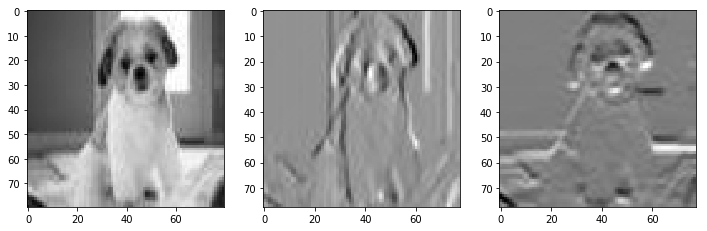

In [6]:
image_sobel_x = signal.convolve2d(image, sobel_x, mode='valid')
image_sobel_y = signal.convolve2d(image, sobel_y, mode='valid')
fig,((a,b,c)) = plt.subplots(1,3, figsize=(12,12))

a.imshow(image, cmap="gray")
b.imshow(image_sobel_x, cmap="gray")
c.imshow(image_sobel_y, cmap="gray")

#### Aplicando convoluciones con kernels aleatorios

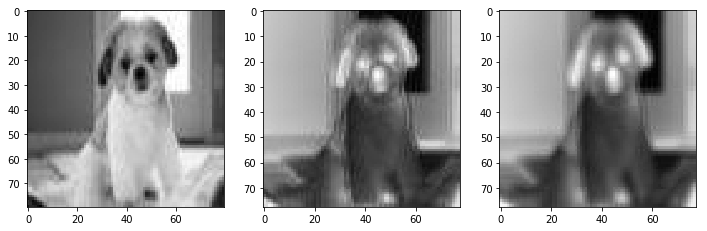

In [7]:
W1 = np.random.randint(-100, 100, (3,3))
W2 = np.random.randint(-2, 2, (3,3))
image_rand_w1_x = signal.convolve2d(image, W1, mode='valid')
image_rand_w2_x = signal.convolve2d(image, W2, mode='valid')
fig,((a,b,c)) = plt.subplots(1,3, figsize=(12,12))

a.imshow(image, cmap="gray")
b.imshow(image_rand_w1_x, cmap="gray")
c.imshow(image_rand_w2_x, cmap="gray")

#### Implementación de convolución en tensorflow

In [8]:
tf.reset_default_graph()
_x = np.array([image[:, :, np.newaxis].astype(np.float32)])
x = tf.get_variable('X', initializer=_x)
W = tf.get_variable('weights', [5, 5, 1, 16], initializer=tf.truncated_normal_initializer(stddev=5e-2, dtype=tf.float32), dtype=tf.float32)
conv1 = tf.nn.conv2d(x, W, [1, 1, 1, 1], 'SAME')
result = None

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    result = sess.run(conv1)
    

In [9]:
result.shape

(1, 80, 80, 16)

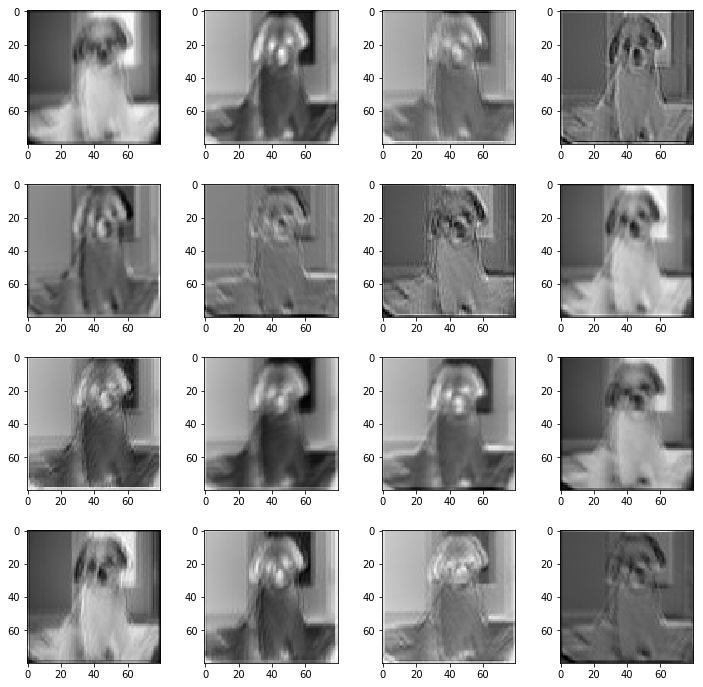

In [10]:
fig, draws = plt.subplots(4,4, figsize=(12,12))
draws = draws.reshape(-1)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for idx in range(result.shape[-1]):    
    draws[idx].imshow(result[0, :, :, idx], cmap="gray")

#### Submuestreo de imagenes (MaxPooling)

Las ConvNets también usan capas de submuestreo para reducir el espacio de características y también ayuda a generalizar el modelo resultante.

Las celdas siguientes muestran como usar submuestreo usando un código de ejemplo de [stackoverflow](https://stackoverflow.com/questions/42463172/how-to-perform-max-mean-pooling-on-a-2d-array-using-numpy) sobre una matriz.

### Max Pooling

$$ x = \begin{bmatrix}
 304 & -779 & -424 &  287 \\
-385 &  617 & -665 &  738 \\
 497 &  974 &  390 & -678 \\
-669 & -854 &  661 & -919 
\end{bmatrix} \;\;\; Maxpool(x, kernelSize: 2, slide: 2) =\begin{bmatrix}
    617 & 738\\
    974 & 661
\end{bmatrix}$$

In [11]:
x = np.array(
    [[ 304, -779, -424,  287],
     [-385,  617, -665,  738],
     [ 497,  974,  390, -678],
     [-669, -854,  661, -919]])

In [12]:
k_size = 2
MK = x.shape[0] // k_size
NL = x.shape[1] // k_size
print(x[:MK*k_size, :NL*k_size].reshape(MK, k_size, NL, k_size).max(axis=(1, 3)))

[[617 738]
 [974 661]]


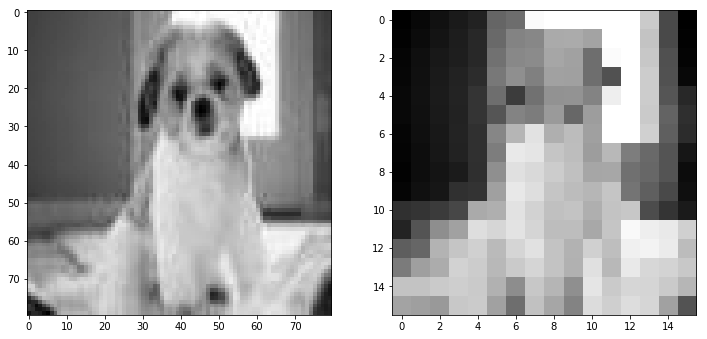

In [13]:
k_size = 5
MK = image.shape[0] // k_size
NL = image.shape[1] // k_size

image_max_pool_2 = image[:MK*k_size, :NL*k_size].reshape(MK, k_size, NL, k_size).max(axis=(1, 3))
fig,((a,b)) = plt.subplots(1,2, figsize=(12,12))

a.imshow(image, cmap="gray")
b.imshow(image_max_pool_2, cmap="gray")


#### Implementación de maxpooling en tensorflow

In [14]:
tf.reset_default_graph()
_x = np.array([image[:, :, np.newaxis].astype(np.float32)])
x = tf.get_variable('X', initializer=_x)
pool1 = tf.nn.max_pool(x, ksize=[1, 3, 3, 1], strides=[1, 2, 2, 1], padding="VALID")
result = None

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    result = sess.run(pool1)

print("image after pooling", result.shape)

image after pooling (1, 39, 39, 1)


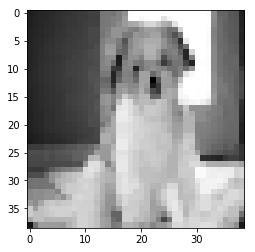

In [15]:
plt.imshow(result[0, :, :, 0], cmap="gray")

#### StandardNetworks vs ConvNetworks

En las celdas anteriores se mostró como funcionan las convoluciones y el subsampling de imágenes, se mostró como usarlas en tensorflow. En lo que queda del notebook se mostrara lo siguiente:

    1. Construir, entrenar y probar una red estándar para clasificar lenguaje de señas
    2. Construir, entrenar y probar una red ConvNet  para clasificar lenguaje de señas
    3. Usar un ConvNet con arquitectura LeNet-5 para clasificar cuando una imagen tiene un rostro humano o no

### Lenguaje de señas
<img src="https://upload.wikimedia.org/wikipedia/commons/2/21/Lengua_de_Signos_%28Bonet%2C_1620%29_B%2C_C%2C_D.jpg" width="180px">

En las próximas celdas vamos usar una red para clasificar lenguaje de señas. La entrada de la red es una imagen de una mano haciendo una seña y la salida de la red es letra del alfabeto que corresponde a esa señal hecha por la mano.

##### Datos

Los datos para este experimento son un subconjunto del dataset que se puede encontrar en [Kaggle - Sign Language MNIST](https://www.kaggle.com/datamunge/sign-language-mnist)

##### Conocimiento previo

En el notebook [Notebook 1](notebook2.ipynb) se usaron herramientas como pandas, scikit-learn y tensorflow para definir redes y se realizaron los seguientes pasos:

1. Preparar los datos en un conjunto de entrenamiento y otro de pruebas
2. Definir las variables y las operaciones de la red
3. Definir las operaciones de aprendizaje de la red
4. Inicializar la red en una sesión de tensorflow
5. Entrenar la red con las operaciones de aprendizaje durante (n) epocas
6. Medir la precisición de la red y probar la red

In [16]:
sing_hand_data = pd.read_csv('./data/hands_signs.csv', index_col=None)

In [17]:
print(sing_hand_data['letter'].unique().tolist())

['H', 'G', 'F', 'S', 'T', 'R', 'V', 'U', 'M', 'E', 'P', 'X', 'D', 'L', 'C', 'W', 'I', 'N', 'Q', 'Y', 'A', 'K', 'O', 'B']


In [18]:
sing_hand_data['label'] = LabelEncoder().fit_transform(sing_hand_data['letter'])

In [19]:
sing_hand_data.head(5)

,letter,path,label
0,H,./data/sign-language-mnist/H/12449.jpg,7
1,G,./data/sign-language-mnist/G/6771.jpg,6
2,F,./data/sign-language-mnist/F/19938.jpg,5
3,S,./data/sign-language-mnist/S/23951.jpg,17
4,H,./data/sign-language-mnist/H/8871.jpg,7


In [20]:
x_train, x_test, y_train, y_test = train_test_split(sing_hand_data['path'], sing_hand_data['label'], test_size=0.2)

In [21]:
im = cv2.imread(sing_hand_data["path"][36], 0)
print("Letter: ", sing_hand_data["letter"][36])


Letter:  C


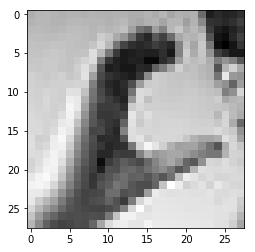

In [22]:
plt.imshow(im, cmap="gray")

In [23]:
#helper functions
def get_images(images_path, newaxis=False):
    images = []
    for path in images_path:
        if newaxis:
            im = cv2.imread(path, 0)[:, :, np.newaxis].astype(np.float32)
        else:
            im = cv2.imread(path, 0)
        images.append(im)

    return np.array(images)

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy_ = sess.run(accuracy, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy_ * len(batch_x))
    return total_accuracy / num_examples

signs_labels = [chr(i) for i in range(ord('A'), ord('Z')+1)]

### Red estándar

In [24]:
tf.reset_default_graph()
tf.set_random_seed(1)

x = tf.placeholder(tf.float32, (None, 28,28), name="X") 
y = tf.placeholder(tf.int32, (None), name="Y")
y_one_hot = tf.one_hot(y, 24)

# parameters layer 1
_x = flatten(x)
b1 = tf.get_variable("b1", initializer = np.zeros(392, dtype=np.float32))
W1 = tf.get_variable("W1", (392, 784), initializer = tf.truncated_normal_initializer())
Z1 = tf.add(tf.tensordot(_x, tf.transpose(W1), [[1], [0]]), b1)
A1 = tf.nn.relu(Z1)

# parameters layer 2
b2  = tf.get_variable("b2", initializer = np.zeros(196, dtype=np.float32))
W2 = tf.get_variable("W2", (196, 392), initializer = tf.truncated_normal_initializer())
Z2 = tf.add(tf.tensordot(A1, tf.transpose(W2), [[1], [0]]), b2)
A2 = tf.nn.relu(Z2)

# parameters output layer
W_l = tf.get_variable("W_l", (24, 196), initializer=tf.truncated_normal_initializer())
b_l = tf.get_variable("b_l", initializer=np.zeros(24, dtype=np.float32))

logits = tf.add(tf.tensordot(A2, W_l, [[1], [1]]), b_l)

# trainning
entropy   = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_one_hot)
loss      = tf.reduce_mean(entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train     = optimizer.minimize(loss)
correct   = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))
accuracy  = tf.reduce_mean(tf.cast(correct, tf.float32))
saver = tf.train.Saver()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.



In [25]:
BATCH_SIZE = 64
EPOCHS = 21
EVALUATE_EVERY_N_EPOCHS = 5

writer = tf.summary.FileWriter('./graph', tf.get_default_graph())
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train)
    
    t0 = time.time()
    for epoch in range(EPOCHS):

        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = get_images(x_train[offset:end]), y_train[offset:end]
            sess.run(train, feed_dict={x: batch_x, y: batch_y})

        if (epoch % EVALUATE_EVERY_N_EPOCHS) == 0:
            train_accuracy = evaluate(get_images(x_train), y_train)
            validation_accuracy = evaluate(get_images(x_test), y_test)
            fortmat_string = "EPOCH({})\t -> Train Accuracy = {:.3f} | Validation Accuracy = {:.3f}"
            print(fortmat_string.format(epoch, train_accuracy, validation_accuracy))
    t1 = time.time()
    total = t1-t0
    print("trainning elapsed time", round(total, 2), "seconds")
    saver.save(sess, './networks_std')
writer.close()

EPOCH(0)	 -> Train Accuracy = 0.216 | Validation Accuracy = 0.211
EPOCH(5)	 -> Train Accuracy = 0.689 | Validation Accuracy = 0.644
EPOCH(10)	 -> Train Accuracy = 0.869 | Validation Accuracy = 0.840
EPOCH(15)	 -> Train Accuracy = 0.929 | Validation Accuracy = 0.907
EPOCH(20)	 -> Train Accuracy = 0.966 | Validation Accuracy = 0.950
trainning elapsed time 39.7 seconds


### Predicción

En la siguiente celda se probara el modelo sobre nuevos imagenes

In [26]:
signs_images_path = glob.glob("./images/signs/*.png")
signs_images = [cv2.resize(im, (28,28)) for im in get_images(signs_images_path)]

In [27]:
preds = None
logs  = None
pred_labels = None
with tf.Session() as sess:
    saver.restore(sess, './networks_std')
    prediction = tf.nn.softmax(logits)
    preds, logs = sess.run([prediction, logits], feed_dict={ x: signs_images })
    pred_labels = np.argmax(preds, axis=1)



INFO:tensorflow:Restoring parameters from ./networks_std


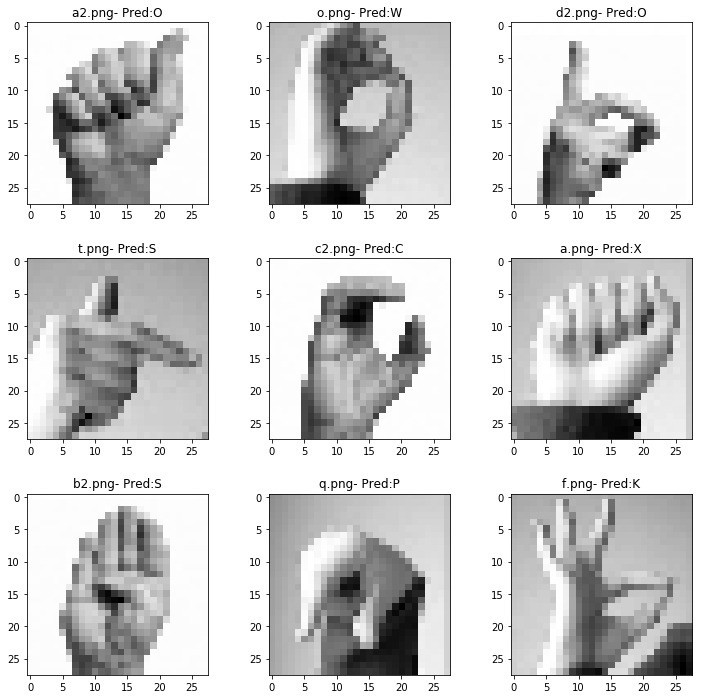

In [28]:
fig, draws = plt.subplots(3,3, figsize=(12,12))
draws = draws.reshape(-1)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for idx in range(9):
    draws[idx].set_title(signs_images_path[idx].split("/")[-1] + "- Pred:" + signs_labels[pred_labels[idx]])
    im =  cv2.resize(signs_images[idx], (28,28))
    draws[idx].imshow(im, cmap="gray")


In [29]:
np.argmax(logs, axis=1)

array([14, 22, 14, 18,  2, 23, 18, 15, 10])

In [30]:
signs_labels[8]

'I'

#### Numero de parámetros

Ahora vamos a calcular el numero de parámetros de la red de señas para esto usaremos los parámetros W's y b's
con el método `get_shape` y `as_list` esto retorna un lista con las dimensiones de ese parámetro
ejemplo:

`W1.get_shape().as_list()` retorna `[392, 784]` vamos a crear un método para extraer el número total de parámetros
de la red pasandole una lista de las variable que representan estos parámetros que son W's y b's

In [31]:
def get_total_params(params_list):
    total_params = 0
    for param in params_list:
        param_dim = param.get_shape().as_list()
        
        total_param_dimension = 1
        for num in param_dim:
            total_param_dimension = total_param_dimension * num
            
        total_params = total_params + total_param_dimension
        
    return [total_params, '{:,}'.format(total_params)]


In [32]:
param_numbers = get_total_params([W1, b1, W2, b2, W_l, b_l])
param_numbers

[389476, '389,476']

In [33]:
mark_text = "#### Standard Network Total Parameters = {} ".format(param_numbers[1])
display(Markdown(mark_text))

#### Standard Network Total Parameters = 389,476 

### ConvNet

In [34]:
tf.reset_default_graph()
tf.set_random_seed(1)

x = tf.placeholder(tf.float32, (None, 28,28, 1), name="X") 
y = tf.placeholder(tf.int32, (None), name="Y")
y_one_hot = tf.one_hot(y, 24)

# parameters layer 1
b1 = tf.get_variable("b1", initializer = np.zeros(16, dtype=np.float32))
W1 = tf.get_variable("W1", (8, 8, 1, 16), initializer = tf.truncated_normal_initializer())
Z1 = tf.nn.conv2d(x, W1, strides=[1, 3, 3, 1], padding='VALID') + b1
A1 = tf.nn.relu(Z1)

b2_ = tf.get_variable("b2_", initializer = np.zeros(32, dtype=np.float32))
W2_ = tf.get_variable("W2_", (4, 4, 16, 32), initializer = tf.truncated_normal_initializer())
Z2_ = tf.nn.conv2d(A1, W2_, strides=[1, 3, 3, 1], padding='VALID') + b2_
A2_ = flatten(tf.nn.relu(Z1))


# parameters layer 2
W2 = tf.get_variable("W2", (784, 196), initializer = tf.truncated_normal_initializer())
b2  = tf.get_variable("b2", initializer = np.zeros(196, dtype=np.float32))
Z2 = tf.add(tf.tensordot(A2_, W2, [[1], [0]]), b2)
A2 = tf.nn.relu(Z2)

# parameters output layer
W_l = tf.get_variable("W_l", (196, 24), initializer=tf.truncated_normal_initializer())
b_l = tf.get_variable("b_l", initializer=np.zeros(24, dtype=np.float32))

logits = tf.add(tf.tensordot(A2, W_l, [[1], [0]]), b_l)

# trainning
entropy   = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_one_hot)
loss      = tf.reduce_mean(entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train     = optimizer.minimize(loss)
correct   = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))
accuracy  = tf.reduce_mean(tf.cast(correct, tf.float32))

saver = tf.train.Saver()

In [35]:
BATCH_SIZE = 64
EPOCHS = 21
EVALUATE_EVERY_N_EPOCHS = 5 # epochs

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train)

    t0 = time.time()
    for epoch in range(EPOCHS):

        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = get_images(x_train[offset:end], newaxis=True), y_train[offset:end]
            sess.run(train, feed_dict={x: batch_x, y: batch_y})

        if (epoch % EVALUATE_EVERY_N_EPOCHS) == 0:
            train_accuracy = evaluate(get_images(x_train, newaxis=True), y_train)
            validation_accuracy = evaluate(get_images(x_test, newaxis=True), y_test)
            fortmat_string = "EPOCH({})\t -> Train Accuracy = {:.3f} | Validation Accuracy = {:.3f}"
            print(fortmat_string.format(epoch, train_accuracy, validation_accuracy))
    t1 = time.time()
    total = t1-t0
    print("trainning elapsed time", round(total, 2), "seconds")
    saver.save(sess, './networks_conv_v1')

EPOCH(0)	 -> Train Accuracy = 0.093 | Validation Accuracy = 0.085
EPOCH(5)	 -> Train Accuracy = 0.600 | Validation Accuracy = 0.539
EPOCH(10)	 -> Train Accuracy = 0.874 | Validation Accuracy = 0.816
EPOCH(15)	 -> Train Accuracy = 0.957 | Validation Accuracy = 0.904
EPOCH(20)	 -> Train Accuracy = 0.987 | Validation Accuracy = 0.942
trainning elapsed time 36.22 seconds


### prediction

In [36]:
preds = None
logs  = None
pred_labels = None
with tf.Session() as sess:
    saver.restore(sess, './networks_conv_v1')
    prediction = tf.nn.softmax(logits)
    preds, logs = sess.run([prediction, logits], feed_dict={ x: [x_[:,:, np.newaxis] for x_ in signs_images] })
    pred_labels = np.argmax(preds, axis=1)



INFO:tensorflow:Restoring parameters from ./networks_conv_v1


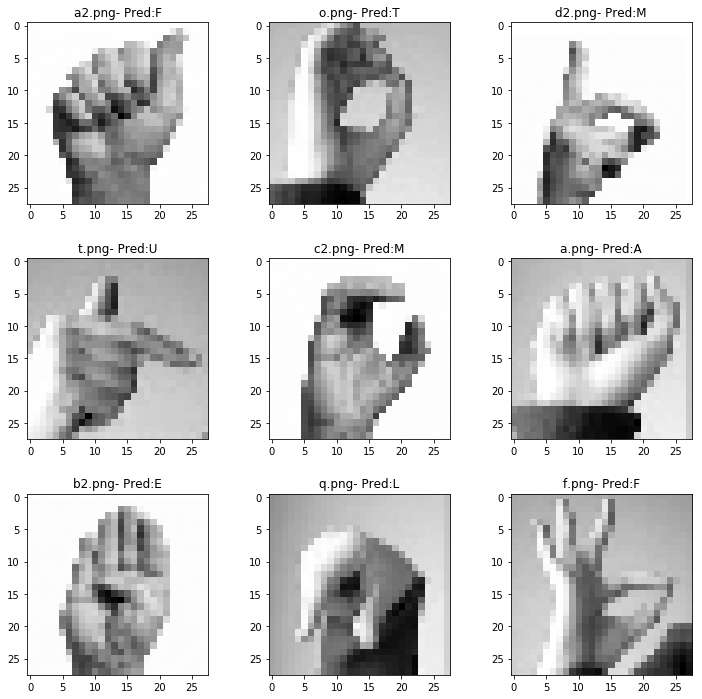

In [37]:
fig, draws = plt.subplots(3,3, figsize=(12,12))
draws = draws.reshape(-1)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for idx in range(9):
    draws[idx].set_title(signs_images_path[idx].split("/")[-1] + "- Pred:" + signs_labels[pred_labels[idx]])
    im =  cv2.resize(signs_images[idx], (28,28))
    draws[idx].imshow(im, cmap="gray")


In [38]:
param_numbers = get_total_params([W1, b1, W2_, b2_, W2, b2, W_l, b_l])
param_numbers

[167852, '167,852']

In [39]:
mark_text = "#### ConvNet Total Parameters = {} ".format(param_numbers[1])
display(Markdown(mark_text))

#### ConvNet Total Parameters = 167,852 

### LeNet-5 Architecture

<img src="https://moisesvw.github.io/img/lenet-5.png">
fuente: [Yan LeCun](http://yann.lecun.com/exdb/lenet/)

La estructura de esta red es la siguiente:
- Imagen de entrada de 32x32 pixeles
- Convolución 1 kernel(5, 5), 6 filtros
- Submuestreo con Maxpooling kernel(2,2), slides(2,2)
- Convolución 2 kernel(5, 5), 16 filtros
- Submuestreo con Maxpooling kernel(2,2), slides(2,2)
- red estandar 120
- red estandar 84
- salida 10 (softmax)

Este ejercicio usa un subconjunto de los datos originales que se pueden encontrar en estos enlaces

- http://vis-www.cs.umass.edu/lfw
- https://www.kaggle.com/slothkong/10-monkey-species/data
- http://vision.stanford.edu/aditya86/ImageNetDogs/



#### Preparación de datos

In [40]:
images_path = glob.glob("./data/faces/**/*.jpg")
labels = { 'faces': 1, 'no_faces': 0 }
data = pd.DataFrame([ {'path': x, 'label': labels[x.split("/")[-2]]} for x in images_path]).sample(4000)

In [41]:
data.head()

,label,path
1508,0,./data/faces/no_faces/n02112137_16777.jpg
3331,1,./data/faces/faces/Astou_Ndiaye-Diatta_0001.jpg
3048,1,./data/faces/faces/Frank_Stallone_0002.jpg
2078,1,./data/faces/faces/Mona_Rishmawi_0001.jpg
1765,0,./data/faces/no_faces/n02111500_8610.jpg


In [42]:
data.groupby('label').count()

,path
label,
0,2000
1,2000


In [43]:
x_train, x_test, y_train, y_test = train_test_split(data['path'], data['label'], test_size=0.1)

#### Modelo

In [44]:
tf.reset_default_graph()
tf.set_random_seed(1)

x = tf.placeholder(tf.float32, (None, 80,80, 1), name="X") 
y = tf.placeholder(tf.int32, (None), name="Y")
y_one_hot = tf.one_hot(y, 2)

# parameters layer 1
W1 = tf.get_variable("W1", (5, 5, 1, 6), initializer = tf.truncated_normal_initializer())
b1 = tf.get_variable("b1", initializer = np.zeros(6, dtype=np.float32))
Z1 = tf.nn.conv2d(x, W1, strides=[1, 1, 1, 1], padding='VALID') + b1
A1 = tf.nn.relu(Z1)
A1max_pool = tf.nn.max_pool(A1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")

# parameters layer 2
W2 = tf.get_variable("W2", (5, 5, 6, 16), initializer = tf.truncated_normal_initializer())
b2 = tf.get_variable("b2", initializer = np.zeros(16, dtype=np.float32))
Z2 = tf.nn.conv2d(A1max_pool, W2, strides=[1, 1, 1, 1], padding='VALID') + b2
A2 = tf.nn.relu(Z2)
A2max_pool = tf.nn.max_pool(A2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding="VALID")
A2flat = flatten(A2max_pool)

# parameters layer 3
W3 = tf.get_variable("W3", (4624, 120), initializer = tf.truncated_normal_initializer())
b3 = tf.get_variable("b3", initializer = np.zeros(120, dtype=np.float32))
Z3 = tf.add(tf.tensordot(A2flat, W3, [[1], [0]]), b3)
A3 = tf.nn.relu(Z3)

# parameters layer 4
W4 = tf.get_variable("W4", (120, 84), initializer = tf.truncated_normal_initializer())
b4  = tf.get_variable("b4", initializer = np.zeros(84, dtype=np.float32))
Z4 = tf.add(tf.tensordot(A3, W4, [[1], [0]]), b4)
A4 = tf.nn.relu(Z4)

# parameters output layer
W_l = tf.get_variable("W_l", (84, 2), initializer=tf.truncated_normal_initializer())
b_l = tf.get_variable("b_l", initializer=np.zeros(2, dtype=np.float32))

logits = tf.add(tf.tensordot(A4, W_l, [[1], [0]]), b_l)

# trainning
entropy   = tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=y_one_hot)
loss      = tf.reduce_mean(entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train     = optimizer.minimize(loss)
correct   = tf.equal(tf.argmax(logits, 1), tf.argmax(y_one_hot, 1))
accuracy  = tf.reduce_mean(tf.cast(correct, tf.float32))

saver = tf.train.Saver()

In [45]:
BATCH_SIZE = 64
EPOCHS = 5
EVALUATE_EVERY_N_EPOCHS = 5 # epochs

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(x_train)

    t0 = time.time()
    for epoch in range(EPOCHS):

        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = get_images(x_train[offset:end], newaxis=True), y_train[offset:end]

            sess.run(train, feed_dict={x: batch_x, y: batch_y})

        if (epoch % EVALUATE_EVERY_N_EPOCHS) == 0:
            train_accuracy = evaluate(get_images(x_train, newaxis=True), y_train)
            validation_accuracy = evaluate(get_images(x_test, newaxis=True), y_test)
            fortmat_string = "EPOCH({})\t -> Train Accuracy = {:.3f} | Validation Accuracy = {:.3f}"
            print(fortmat_string.format(epoch, train_accuracy, validation_accuracy))
    t1 = time.time()
    total = t1-t0
    print("trainning elapsed time", round(total, 2), "seconds")
    saver.save(sess, './lenet-5')

EPOCH(0)	 -> Train Accuracy = 0.725 | Validation Accuracy = 0.700
trainning elapsed time 45.62 seconds


### prediccion

In [46]:
test_images = [ cv2.resize(x, (80,80)) for x in get_images(glob.glob("./images/faces/*.jpg")) ]


In [47]:
preds = None
logs  = None
pred_labels = None
with tf.Session() as sess:
    saver.restore(sess, './lenet-5')
    prediction = tf.nn.softmax(logits)
    preds, logs = sess.run([prediction, logits], feed_dict={ x: [x_[:,:, np.newaxis] for x_ in test_images] })
    pred_labels = np.argmax(logs, axis=1)


INFO:tensorflow:Restoring parameters from ./lenet-5


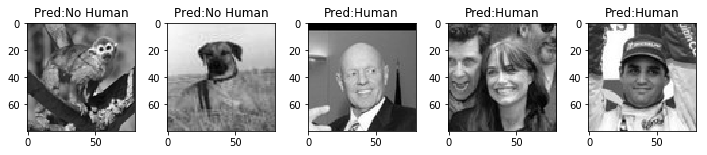

In [48]:
labels = { 1: "Human", 0: "No Human" }
fig, draws = plt.subplots(1,5, figsize=(12,12))
draws = draws.reshape(-1)
fig.subplots_adjust(wspace=0.3, hspace=0.3)

for idx in range(len(pred_labels)):
    draws[idx].set_title("Pred:" + labels[pred_labels[idx]])
    im =  test_images[idx]
    draws[idx].imshow(im, cmap="gray")